## Predicting Customer Churn 
In this notebook, I will use two algorithms: <b>Random Forest</b> and <b>Logistic Regression</b> to predict customer churn. </br></br>
I will first clean the data and declare dependent and independent variables for data modeling. For each algorithms, I also scale the features to make sure the model can account for the imbalance of each class (number of customers of each group: churned, stayed, or joined). I will also evaluate each model to see which one is more accurate and suitable to use in our case. I will look briefly at feature importance to see which variables are importance in predicting customer status.

### Import packages to use and prepare the dataset

In [200]:
# import packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
from sklearn import metrics

In [202]:
filepath = '/Users/tu/Documents/Tu/Data_Portfolio/Customer_churn/Dataset/a_IBM Telco Customers Churn Datasets.xlsx'
sheets = pd.ExcelFile(filepath).sheet_names

# Read all sheets into a dictionary of DataFrames
dataframes = {sheet: pd.read_excel(filepath, sheet_name=sheet) for sheet in sheets}

In [203]:
# merge relevant cols
customer_info = dataframes['Customer_Info'][['gender', 'age', 'under_30', 'senior_citizen', 'partner', 'dependents', 'number_of_dependents', 'married' ]]
service_options = dataframes['Service_Options'][['internet_service', 'multiple_lines', 'unlimited_data', 'referred_a_friend', 'tenure']]
online_services = dataframes['Online_Services'][['phone_service', 'online_security', 'online_backup', 'device_protection', 'premium_tech_support', 'streaming_tv', 'streaming_movies', 'streaming_music']]
payment_info = dataframes['Payment_Info'][['contract', 'payment_method', 'monthly_ charges', 'total_revenue']]
status_analysis = dataframes['Status_Analysis'][['customer_status','satisfaction_score', 'churn_label', 'churn_score', 'cltv']]

In [204]:
# Merge all dataframes
data = pd.concat([customer_info, service_options, online_services, payment_info, status_analysis], axis=1)

# Handle missing values
data =data.dropna()
data.head(5)

,gender,age,under_30,senior_citizen,partner,dependents,number_of_dependents,married,internet_service,multiple_lines,...,streaming_music,contract,payment_method,monthly_ charges,total_revenue,customer_status,satisfaction_score,churn_label,churn_score,cltv
0,Female,37,No,No,Yes,No,0,Yes,Yes,No,...,No,One Year,Mailed check,65.6,974.81,Stayed,3,No,65,2205
1,Male,46,No,No,No,No,0,No,Yes,Yes,...,Yes,Month-to-Month,Mailed check,59.9,610.28,Stayed,5,No,66,5414
2,Male,50,No,No,No,No,0,No,Yes,No,...,No,Month-to-Month,Electronic check,73.9,415.45,Churned,1,Yes,71,4479
3,Male,78,No,Yes,Yes,No,0,Yes,Yes,No,...,No,Month-to-Month,Electronic check,98.0,1599.51,Churned,1,Yes,91,3714
4,Female,75,No,Yes,Yes,No,0,Yes,Yes,No,...,No,Month-to-Month,Mailed check,83.9,289.54,Churned,1,Yes,68,3464


In [63]:

label_encoder = LabelEncoder()
label_encoder.fit(["Yes", "No"])
columns_to_map = ['gender', 'under_30', 'senior_citizen', 'partner', 'dependents', 'married', 'internet_service', 'multiple_lines', 'streaming_movies', 'streaming_music',
                    'unlimited_data', 'referred_a_friend', 'phone_service', 'contract', 'payment_method','online_security', 
                        'online_backup', 'device_protection', 'premium_tech_support', 'streaming_tv', 'churn_label'
                         ]
for col in columns_to_map:
    data[col] = label_encoder.fit_transform(data[col])

cols_to_convert = ['monthly_ charges', 'total_revenue']

for col in cols_to_convert: 
    data[col] = data[col].map(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else x)

In [143]:
# normalize data
scaler = StandardScaler()
numerical_cols =  ['age', 'monthly_ charges', 'total_revenue', 'satisfaction_score', 'churn_score', 'cltv']
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

In [198]:
data.head(5)

,gender,age,under_30,senior_citizen,partner,dependents,number_of_dependents,married,internet_service,multiple_lines,...,streaming_music,contract,payment_method,monthly_ charges,total_revenue,customer_status,satisfaction_score,churn_label,churn_score,cltv
0,0,-0.567773,0,0,1,0,0,1,1,0,...,0,1,3,0.027862,-0.718872,Stayed,-0.203836,0,0.306822,-1.855744
1,1,-0.030433,0,0,0,0,0,0,1,1,...,1,0,3,-0.161583,-0.846108,Stayed,1.460650,0,0.354061,0.856912
2,1,0.208385,0,0,0,0,0,0,1,0,...,0,0,2,0.303720,-0.914111,Churned,-1.868323,1,0.590261,0.066531
3,1,1.880110,0,1,1,0,0,1,1,0,...,0,0,2,1.104706,-0.500827,Churned,-1.868323,1,1.535060,-0.580145
4,0,1.700997,0,1,1,0,0,1,1,0,...,0,0,3,0.636080,-0.958059,Churned,-1.868323,1,0.448541,-0.791477


### Data Modeling & Model Evaluation

In [191]:
# assign dependent and independent variables
features =  data.drop(columns = ['customer_status'])
churn = data['customer_status']

X_train, X_test, y_train, y_test = train_test_split(features, churn, test_size = 0.4, random_state = 2)

### - Random Forest Classifier

In [193]:
# random foresr classifiers
rf = RandomFoestClassifier(random_state = 42)
rf.fit(X_train, y_train)

# Random Forest predictions
rf_pred = rf.predict(X_test)

# Random Forest evaluation 
print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred))



[[ 749    0    0]
 [   0  184    0]
 [   0    1 1884]]
              precision    recall  f1-score   support

     Churned       1.00      1.00      1.00       749
      Joined       0.99      1.00      1.00       184
      Stayed       1.00      1.00      1.00      1885

    accuracy                           1.00      2818
   macro avg       1.00      1.00      1.00      2818
weighted avg       1.00      1.00      1.00      2818



<b> Overfitting! </b> </br>
This model is likely overfitting, so it is not ideal to be used to predict customer status. In order to provide a more accurate mode, I will use GridSearchCV for hyperparameter tuning and find the best parameters combination to fit the model.

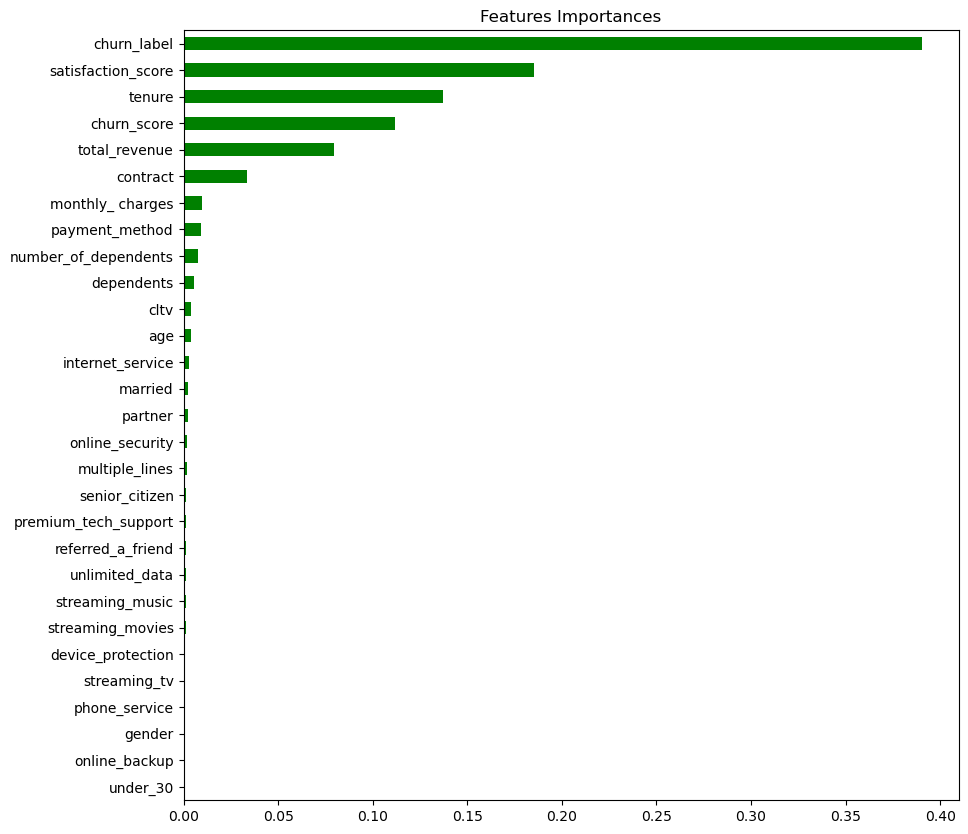

In [147]:
# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
plt.figure(figsize =  (10,10))
importances_sorted.plot(kind='barh', color='green')
plt.title('Features Importances')
plt.show()

<b> Feature Importance </b> </br>
Factors such as number of months customers staying with Telco and monetary-related features (like total revenue, total charges, monthly charge, or total long distance charges) are important in predicting the likelihood of customer churn. Type of offers seems to be irrelevant in churn prediction, except for customers who receive offer E. 

In [85]:
# Model tuning
rf_params = {'n_estimators': [100, 350, 500],
    'max_features': ['log2', 'auto', 'sqrt'], 
    'min_samples_leaf': [2, 10, 30]}
grid_rf = GridSearchCV(rf, rf_params, scoring = 'accuracy', cv = 10)
grid_rf.fit(X_train, y_train)

print(grid_rf.best_estimator_)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-pac

RandomForestClassifier(min_samples_leaf=2, random_state=42)


In [89]:
rf = RandomForestClassifier(min_samples_leaf=2, random_state=42)
# Random Forest predictions
rf_pred = grid_rf.predict(X_test)

# Random Forest evaluation 
print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

[[ 556    0    0]
 [   0  136    0]
 [   0    0 1421]]
              precision    recall  f1-score   support

     Churned       1.00      1.00      1.00       556
      Joined       1.00      1.00      1.00       136
      Stayed       1.00      1.00      1.00      1421

    accuracy                           1.00      2113
   macro avg       1.00      1.00      1.00      2113
weighted avg       1.00      1.00      1.00      2113



In [ ]:
print(grid_rf.best_estimator_)

### - Logistic Regression 

#### Fit and evaluate model

In [181]:
# take into account imbalance
smote = SMOTE(random_state = 42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 

# Initiate the logistic regression: customize class weights due to imbalance between different customer status group
logreg = LogisticRegression(class_weight =  {'Churned': 1.25, 'Joined': 5.18, 'Stayed': 0.5},  C=0.001, random_state = 42, max_iter = 900, solver='liblinear')
logreg.fit(X_train_resampled, y_train_resampled)

# Logistic regression predictions
logreg_pred = logreg.predict(X_test)

#Logistic Regression evaluation
print(classification_report(y_test, logreg_pred))

              precision    recall  f1-score   support

     Churned       0.83      0.92      0.87       556
      Joined       0.49      0.99      0.66       136
      Stayed       0.99      0.85      0.92      1421

    accuracy                           0.88      2113
   macro avg       0.77      0.92      0.81      2113
weighted avg       0.91      0.88      0.89      2113



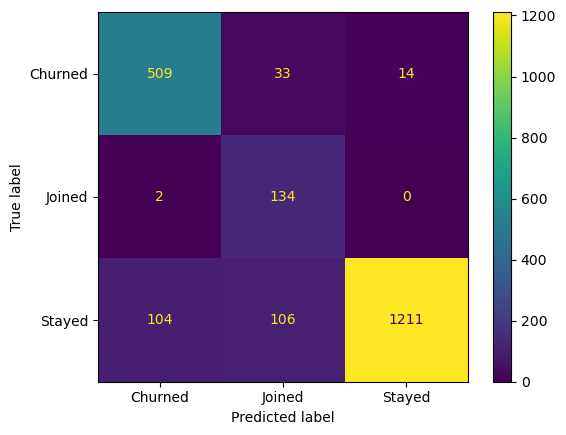

In [183]:
matrix = metrics.confusion_matrix(y_test, logreg_pred)

matrix_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels =  ['Churned', 'Joined', 'Stayed'])

matrix_display.plot()
plt.show()

<b>Evaluation:</b> </br>
The model has a high accuracy (0.88), which mean most of the times, the model give a correct classification for customer status. </br>
Besides, this model is exceptionally good at predicting customers who stayed (0.99 precision score). Using Logistic Regression, we can predict more accurate retention rate compared to churn rate and rate of new customers joining Telco. Unlike the previous model, which utilizing Random Forest Classification, this model is good at predicting churn rate as well.

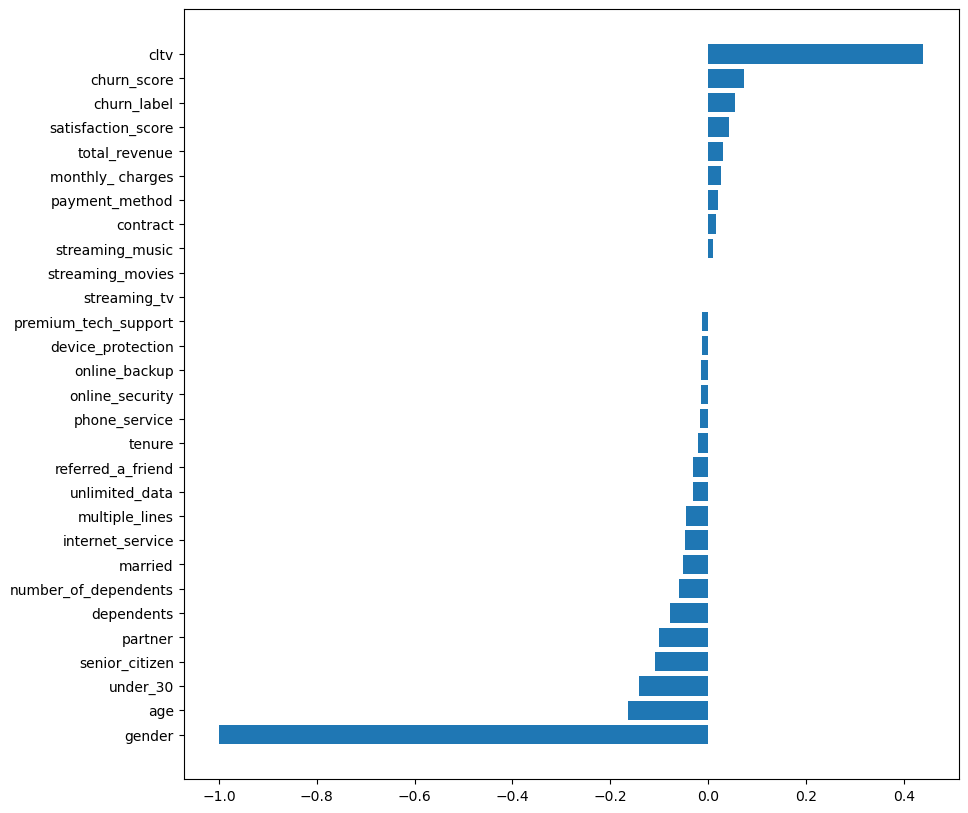

In [163]:
feature_importance = pd.DataFrame({
    'Features': features.columns, 
    'Coefficients': logreg.coef_[0]
})

plt.figure(figsize=(10,10))
plt.barh(feature_importance['Features'], feature_importance['Coefficients'].sort_values())
plt.show()

In [ ]:
# 